In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import qutip
from copy import deepcopy
from CoupledQuantumSystems.systems import FluxoniumOscillatorSystem
from CoupledQuantumSystems.drive import DriveTerm,square_pulse_with_rise_fall
from CoupledQuantumSystems.evo_parrallel import run_parallel_ODEsolve_and_post_process_jobs_with_different_systems

In [18]:
max_ql = 20
max_ol = 300
EJ = 3
EC = EJ/6
EL = EJ/25
Er =  6.8

g = 0.2
w_d = 6.798176579812265
amp = 0.015
kappa = 0.003
tot_time =500
tlist = np.linspace(0, tot_time, tot_time)
system  =  FluxoniumOscillatorSystem(
                EJ = EJ,
                EC = EC,
                EL = EL,
                Er = Er,
                g_strength = g,
                kappa=kappa,
                qubit_level = max_ql,
                osc_level = max_ol,
                products_to_keep=[[ql, ol] for ql in range(max_ql) for ol in range(max_ol) ],
                computaional_states = '1,2',
                )

id_wrapped_resonator_destory = qutip.tensor(qutip.identity(max_ql), qutip.destroy(max_ol))
id_wrapped_fluxonium_destory = qutip.tensor(qutip.destroy(max_ql), qutip.identity(max_ol))
resonator_creation_arr = id_wrapped_resonator_destory.dag().full()
resonator_destory_arr= id_wrapped_resonator_destory.full()
fluxonium_creation_arr = id_wrapped_fluxonium_destory.dag().full()
fluxonium_destory_arr= id_wrapped_fluxonium_destory.full()

ladder_overlap = system.get_ladder_overlap_arr(resonator_creation_arr)
# with open('ef_mcsolve_ladder_overlap_g0.2.pkl', 'wb') as f:
#     pickle.dump(ladder_overlap,f)
def find_next_in_branch(dressed_idx_of_qubit_i_resonator_n:int):
    return np.argmax(ladder_overlap[:,dressed_idx_of_qubit_i_resonator_n])

diagonalization_idx_arr = np.zeros((max_ql,max_ol),dtype=int)
diagonalization_idx_arr_with_marks = np.zeros((max_ql,max_ol),dtype=int)
overlap_idx_arr = np.zeros((max_ql,max_ol),dtype=int)
for ql in range(max_ql):
    for ol in range(max_ol):
        diagonalization_idx_arr[ql,ol] = system.product_to_dressed[(ql,ol)]
        diagonalization_idx_arr_with_marks[ql,ol] = system.product_to_dressed[(ql,ol)]

        if ol < 1:
            overlap_idx_arr[ql,ol] = system.product_to_dressed[(ql,ol)]
        else:
            overlap_idx_arr[ql,ol] = np.argmax(ladder_overlap[:,overlap_idx_arr[ql,ol-1]])

for ql in range(max_ql):
    for ol in range(max_ol):
        system.product_to_dressed[(ql,ol)] =  overlap_idx_arr[ql,ol] 

system.set_sign_multiplier()
with open('ef_mcsolve_system_g0.2.pkl', 'wb') as f:
    pickle.dump(system,f)

In [19]:
system.evals[ system.product_to_dressed[(1,1)] ] - system.evals[ system.product_to_dressed[(1,0)] ], \
system.evals[ system.product_to_dressed[(2,1)] ] - system.evals[ system.product_to_dressed[(2,0)] ],\
system.evals[ system.product_to_dressed[(0,1)] ] - system.evals[ system.product_to_dressed[(0,0)] ]

(6.8011315274183435, 6.801159819556243, 6.798176579812265)

 /tmp/ipykernel_14224/1875598829.py: 18ComplexWarning: Casting complex values to real discards the imaginary part
 /tmp/ipykernel_14224/1875598829.py: 20

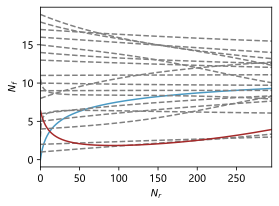

In [20]:
fig,ax = plt.subplots(1,1,figsize=(4,3))
qls = list(range(max_ql))

for ql in qls:
    linestyle = '-'
    if ql == 0:
        color = '#4999c3'
    elif ql == 7:
        color = 'brown'
    else:
        color = 'grey'
        linestyle = '--'
    dressed_idx_arr = overlap_idx_arr[ql]
    photon_num_arr = np.zeros((max_ol))
    fluxonium_num_arr = np.zeros((max_ol))
    for ol in range(max_ol):
        state_after_a = resonator_destory_arr @ system.evecs[dressed_idx_arr[ol]].full()
        photon_num_arr[ol] = np.sum(state_after_a**2)
        state_after_fluxnonium_a = fluxonium_destory_arr @ system.evecs[dressed_idx_arr[ol]].full()
        fluxonium_num_arr[ol] = np.sum(state_after_fluxnonium_a**2)

    ax.plot(photon_num_arr,fluxonium_num_arr,label=f'{ql}',color=color,linestyle=linestyle)


ax.set_xlim(0,max_ol-5)
ax.set_xlabel(r'$N_r$')
ax.set_ylabel(r'$N_f$')

plt.tight_layout()
fig.savefig('hybridization_g0.2.pdf')

In [21]:
initial_states  = [
    qutip.basis(max_ql * max_ol, system.product_to_dressed[(ql,0)]) for ql in [0,1,2]
    ]
products_to_keep_list = [
    [[ql, ol] for ql in [0] for ol in range(max_ol) ],
    [[ql, ol] for ql in [1] for ol in range(max_ol) ],
    [[ql, ol] for ql in [2] for ol in range(max_ol) ]
]

list_of_systems = []
list_of_kwargs = []
for products_to_keep, y0 in zip(products_to_keep_list, initial_states):
    system.set_new_product_to_keep(products_to_keep)
    system.set_new_operators_after_setting_new_product_to_keep()
    list_of_systems.append(deepcopy(system))
    list_of_kwargs.append( {
        'y0':system.truncate_function(y0) ,
        'tlist':tlist,
        'drive_terms':[DriveTerm( 
                            driven_op= system.driven_operator,
                            pulse_shape_func=square_pulse_with_rise_fall,
                            pulse_shape_args={
                                'w_d': w_d ,
                                'amp': amp,
                                't_rise': 20,
                                't_square': tot_time
                            })],
        'e_ops':[system.a_trunc , system.a_trunc.dag()*system.a_trunc],
        # 'c_ops':[kappa *qutip.lindblad_dissipator(system.a_trunc) ]
        })
    

results = run_parallel_ODEsolve_and_post_process_jobs_with_different_systems(
    list_of_systems,
    list_of_kwargs,
    post_processing = ['pad_back']
)

import pickle
with open('sesolve_large_dim_a015.pkl', 'wb') as file:
    pickle.dump(results, file)


 Total run time: 559.43s*] Elapsed 559.43s / Remaining 00:00:00:00


Processing states with pad_back_custom:   5%|▌         | 27/500 [00:00<00:05, 85.07it/s]

 [*********92%*********  ] Elapsed 559.92s / Remaining 00:00:00:48

Processing states with pad_back_custom:  28%|██▊       | 138/500 [00:01<00:04, 81.79it/s]

 [*********99%***********] Elapsed 561.13s / Remaining 00:00:00:05

Processing states with pad_back_custom:  38%|███▊      | 192/500 [00:02<00:03, 84.65it/s]

 [*********92%*********  ] Elapsed 561.62s / Remaining 00:00:00:48

Processing states with pad_back_custom:  46%|████▌     | 228/500 [00:02<00:03, 82.76it/s]

 [*********99%***********] Elapsed 562.17s / Remaining 00:00:00:05

Processing states with pad_back_custom:  63%|██████▎   | 316/500 [00:03<00:02, 84.93it/s]

 [********100%***********] Elapsed 563.47s / Remaining 00:00:00:00

Processing states with pad_back_custom:   1%|▏         | 7/500 [00:00<00:07, 67.56it/s]s]

 Total run time: 564.46s*] Elapsed 564.46s / Remaining 00:00:00:00


Processing states with pad_back_custom:   8%|▊         | 39/500 [00:00<00:06, 73.25it/s]]

 [*********93%*********  ] Elapsed 565.00s / Remaining 00:00:00:42

Processing states with pad_back_custom:  36%|███▌      | 181/500 [00:02<00:03, 84.04it/s]

 [*********93%*********  ] Elapsed 566.63s / Remaining 00:00:00:42

Processing states with pad_back_custom:  66%|██████▌   | 328/500 [00:03<00:02, 85.22it/s]

 [*********93%*********  ] Elapsed 568.31s / Remaining 00:00:00:42

Processing states with pad_back_custom:  91%|█████████▏| 457/500 [00:05<00:00, 86.62it/s]

 [*********93%*********  ] Elapsed 569.88s / Remaining 00:00:00:42

Processing states with pad_back_custom: 100%|██████████| 500/500 [00:06<00:00, 83.23it/s]


 Total run time: 618.65s*] Elapsed 618.65s / Remaining 00:00:00:00


Processing states with pad_back_custom: 100%|██████████| 500/500 [00:05<00:00, 84.01it/s]


In [22]:
with open('sesolve_large_dim_a015.pkl', 'rb') as file:
    results = pickle.load(file)

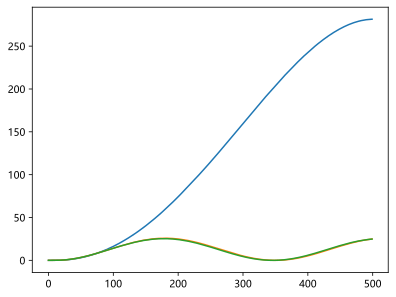

In [24]:
for i in [0,1,2]:
    plt.plot(results[i].expect[1])

(345.0, 350.0)

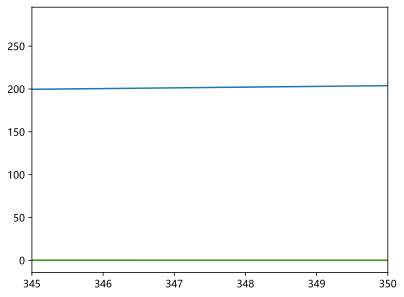

In [25]:
for i in [0,1,2]:
    plt.plot(results[i].expect[1])
plt.xlim(345,350)
# plt.ylim(0,0.01)

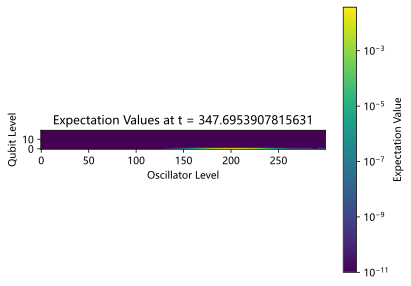

In [26]:
from CoupledQuantumSystems.visualization import *
plot_heatmap(results[0],347,system.product_to_dressed,max_ql,max_ol,LogNorm())

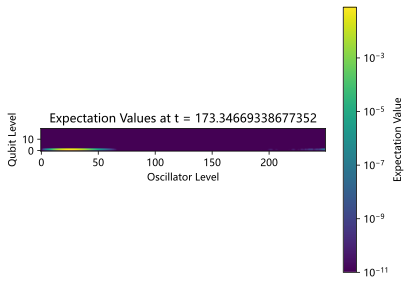

In [17]:
plot_heatmap(results[1],int(347/2),system.product_to_dressed,max_ql,max_ol,LogNorm())